In [1]:
import pickle
from pathlib import Path

import pandas as pd

from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve

from plotting import plot_confusion_matrix

In [2]:
data_dir = Path.cwd() / 'data'
pkl_dir = data_dir / 'pkl'

credit_test = pd.read_pickle(pkl_dir / 'credit_test.pkl')
X_test, y_test = credit_test.drop(columns=['Class']), credit_test['Class']

with open(pkl_dir / 'smote_best.pkl', 'rb') as fp:
    smote_best = pickle.load(fp)
    
    
with open(pkl_dir / 'adasyn_best.pkl', 'rb') as fp:
    adasyn_best = pickle.load(fp)

## Evaluation
My metric of choice is recall, but I will also look into precision as the number of false-positives will affect business decisions should auditing too many non-fraud accounts be more costly than missing a few fraud accounts.

Recall: 94.06%


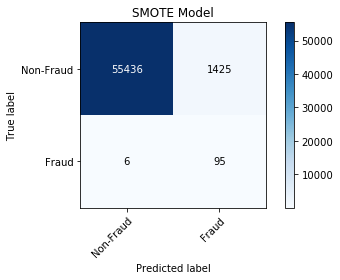

In [3]:
y_pred_smote = smote_best.predict(X_test)
recall_smote = recall_score(y_test, y_pred_smote)
conf_mtx_smote = confusion_matrix(y_test, y_pred_smote)
print(f'Recall: {recall_smote:.2%}')
plot_confusion_matrix(y_test, y_pred_smote, classes=['Non-Fraud', 'Fraud'], title='SMOTE Model');

Recall: 97.03%


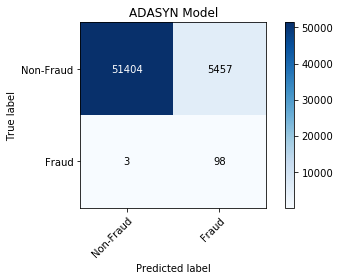

In [4]:
y_pred_adasyn = adasyn_best.predict(X_test)
recall_adasyn = recall_score(y_test, y_pred_adasyn)
conf_mtx_adasyn = confusion_matrix(y_test, y_pred_adasyn)
print(f'Recall: {recall_adasyn:.2%}')
plot_confusion_matrix(y_test, y_pred_adasyn, classes=['Non-Fraud', 'Fraud'], title='ADASYN Model');

### Determining which model to choose

Let $F$ be the cost of leaving a fraudulent account being uncaught.

Let $A$ be the cost of auditing an account to see if it is fraudulent.

Let $f_{\tiny{Model}}$ be the number of uncaught fraudulent accounts (TN) for a given model.

Let $a_{\tiny{Model}}$ be the number of accounts flagged as fraudulent (TP + FP) for a given model.


$$\text{SMOTE } = \text{ADASYN}$$

$$F \cdot f_{\tiny{SMOTE}} + A \cdot a_{\tiny{SMOTE}} = F \cdot f_{\tiny{ADASYN}} + A \cdot a_{\tiny{ADASYN}}$$

$$6F + (1425 + 95)A = 3F + (5457 + 98)A$$

$$6F + 1520A = 3F + 5555A$$

$$3F = 4035A$$

$$F = 1345A$$


Thus if the average cost of leaving a fraudulent account uncaught is 1345 times the cost per audit, the ADASYN model should be the one used.

In [5]:
def select_model(audit_cost, fraud_cost):
    smote_cost = 6 * fraud_cost + 1520 * audit_cost
    adasyn_cost = 3 * fraud_cost + 5555 * audit_cost
    
    if np.isclose(smote_cost, adasyn_cost):
        choice = 'Either'
    elif smote_cost < adasyn_cost:
        choice = 'SMOTE'
    else:
        choice = 'ADASYN'
    
    print(f'SMOTE cost: ${smote_cost:,}')
    print(f'ADASYN cost: ${adasyn_cost:,}')
    print(f'Use the {choice} model')

# assuming audits cost $50 and uncaught fraudulent activity cost $10,000
select_model(audit_cost=50, fraud_cost=10_000)

SMOTE cost: $136,000
ADASYN cost: $307,750
Use the SMOTE model
